In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

In [2]:
class Bandit:
    """A single bandit arm with a true reward probability."""

    def __init__(self, true_mean: float):
        self.true_mean = true_mean
        self.estimated_mean = 0.0
        self.num_pulls = 0

    def pull(self) -> float:
        """Pull the arm and get a reward (1 or 0 with probability true_mean)."""
        return 1 if np.random.random() < self.true_mean else 0

    def update(self, reward: float):
        """Update the estimated mean after receiving a reward."""
        self.num_pulls += 1
        # Incremental update formula
        self.estimated_mean += (reward - self.estimated_mean) / self.num_pulls

In [3]:
class MultiArmedBandit:
    """Multi-Armed Bandit environment with multiple arms."""

    def __init__(self, probabilities: List[float]):
        self.bandits = [Bandit(p) for p in probabilities]
        self.num_arms = len(probabilities)
        self.best_arm = np.argmax(probabilities)

    def reset(self):
        """Reset all bandits."""
        for bandit in self.bandits:
            bandit.estimated_mean = 0.0
            bandit.num_pulls = 0

In [4]:
class EpsilonGreedy:
    """Epsilon-Greedy algorithm for MAB."""

    def __init__(self, epsilon: float = 0.1):
        self.epsilon = epsilon

    def select_arm(self, mab: MultiArmedBandit) -> int:
        """Select an arm using epsilon-greedy strategy."""
        if np.random.random() < self.epsilon:
            # Explore: random arm
            return np.random.randint(mab.num_arms)
        else:
            # Exploit: best known arm
            return np.argmax([b.estimated_mean for b in mab.bandits])

In [5]:
class UCB:
    """Upper Confidence Bound algorithm for MAB."""

    def __init__(self, c: float = 2.0):
        self.c = c
        self.t = 0

    def select_arm(self, mab: MultiArmedBandit) -> int:
        """Select an arm using UCB strategy."""
        self.t += 1

        # Pull each arm once first
        for i, bandit in enumerate(mab.bandits):
            if bandit.num_pulls == 0:
                return i

        # Calculate UCB values
        ucb_values = []
        for bandit in mab.bandits:
            exploration_bonus = self.c * np.sqrt(np.log(self.t) / bandit.num_pulls)
            ucb_values.append(bandit.estimated_mean + exploration_bonus)

        return np.argmax(ucb_values)

In [6]:
class ThompsonSampling:
    """Thompson Sampling algorithm for MAB using Beta distribution."""

    def __init__(self):
        self.alpha = None
        self.beta = None

    def initialize(self, num_arms: int):
        """Initialize prior parameters (uniform prior)."""
        self.alpha = np.ones(num_arms)
        self.beta = np.ones(num_arms)

    def select_arm(self, mab: MultiArmedBandit) -> int:
        """Select an arm by sampling from Beta distributions."""
        if self.alpha is None:
            self.initialize(mab.num_arms)

        # Sample from Beta distribution for each arm
        samples = [np.random.beta(self.alpha[i], self.beta[i])
                   for i in range(mab.num_arms)]
        return np.argmax(samples)

    def update(self, arm: int, reward: float):
        """Update Beta distribution parameters."""
        self.alpha[arm] += reward
        self.beta[arm] += (1 - reward)

In [7]:
def run_experiment(mab: MultiArmedBandit, algorithm, num_steps: int = 1000) -> Tuple[List[float], List[float], List[int]]:
    """Run a single experiment with given algorithm."""
    mab.reset()

    rewards = []
    cumulative_rewards = []
    optimal_actions = []
    total_reward = 0
    optimal_count = 0

    # Special handling for Thompson Sampling
    if isinstance(algorithm, ThompsonSampling):
        algorithm.alpha = None
        algorithm.beta = None

    # Special handling for UCB
    if isinstance(algorithm, UCB):
        algorithm.t = 0

    for step in range(num_steps):
        # Select arm
        arm = algorithm.select_arm(mab)

        # Pull arm and get reward
        reward = mab.bandits[arm].pull()

        # Update bandit estimate
        mab.bandits[arm].update(reward)

        # Update Thompson Sampling parameters
        if isinstance(algorithm, ThompsonSampling):
            algorithm.update(arm, reward)

        # Track metrics
        total_reward += reward
        rewards.append(reward)
        cumulative_rewards.append(total_reward)

        if arm == mab.best_arm:
            optimal_count += 1
        optimal_actions.append(optimal_count / (step + 1) * 100)

    return rewards, cumulative_rewards, optimal_actions

In [8]:
def run_comparison(probabilities: List[float], num_steps: int = 1000, num_runs: int = 100):
    """Compare different algorithms."""

    algorithms = {
        'ε-Greedy (ε=0.1)': EpsilonGreedy(epsilon=0.1),
        'ε-Greedy (ε=0.01)': EpsilonGreedy(epsilon=0.01),
        'UCB (c=2)': UCB(c=2.0),
        'Thompson Sampling': ThompsonSampling()
    }

    results = {name: {'rewards': [], 'cumulative': [], 'optimal': []}
               for name in algorithms.keys()}

    print("Running experiments...")
    for run in range(num_runs):
        if (run + 1) % 20 == 0:
            print(f"Run {run + 1}/{num_runs}")

        for name, algorithm in algorithms.items():
            mab = MultiArmedBandit(probabilities)
            rewards, cumulative, optimal = run_experiment(mab, algorithm, num_steps)

            results[name]['rewards'].append(rewards)
            results[name]['cumulative'].append(cumulative)
            results[name]['optimal'].append(optimal)

    # Average results
    avg_results = {}
    for name in algorithms.keys():
        avg_results[name] = {
            'rewards': np.mean(results[name]['rewards'], axis=0),
            'cumulative': np.mean(results[name]['cumulative'], axis=0),
            'optimal': np.mean(results[name]['optimal'], axis=0)
        }

    return avg_results

In [9]:
def plot_results(results: dict, probabilities: List[float]):
    """Plot comparison results."""

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Average Reward over time
    ax = axes[0]
    for name, data in results.items():
        # Use moving average for smoother plot
        window = 50
        smoothed = np.convolve(data['rewards'], np.ones(window)/window, mode='valid')
        ax.plot(smoothed, label=name, linewidth=2)

    ax.set_xlabel('Steps', fontsize=12)
    ax.set_ylabel('Average Reward', fontsize=12)
    ax.set_title('Average Reward Over Time', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Cumulative Reward
    ax = axes[1]
    for name, data in results.items():
        ax.plot(data['cumulative'], label=name, linewidth=2)

    ax.set_xlabel('Steps', fontsize=12)
    ax.set_ylabel('Cumulative Reward', fontsize=12)
    ax.set_title('Cumulative Reward', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 3: Optimal Action Selection %
    ax = axes[2]
    for name, data in results.items():
        ax.plot(data['optimal'], label=name, linewidth=2)

    ax.set_xlabel('Steps', fontsize=12)
    ax.set_ylabel('Optimal Action %', fontsize=12)
    ax.set_title('Optimal Action Selection', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('mab_comparison.png', dpi=300, bbox_inches='tight')
    print("\nPlot saved as 'mab_comparison.png'")
    plt.show()

Bandit probabilities: [0.1, 0.3, 0.5, 0.7, 0.9]
Optimal arm: 4 (probability: 0.9)
Running experiments...
Run 20/100
Run 40/100
Run 60/100
Run 80/100
Run 100/100

FINAL RESULTS (averaged over 100 runs)

ε-Greedy (ε=0.1):
  Total Reward: 826.15
  Optimal Action %: 82.92%

ε-Greedy (ε=0.01):
  Total Reward: 645.56
  Optimal Action %: 48.89%

UCB (c=2):
  Total Reward: 786.43
  Optimal Action %: 68.12%

Thompson Sampling:
  Total Reward: 885.30
  Optimal Action %: 95.89%

Plot saved as 'mab_comparison.png'


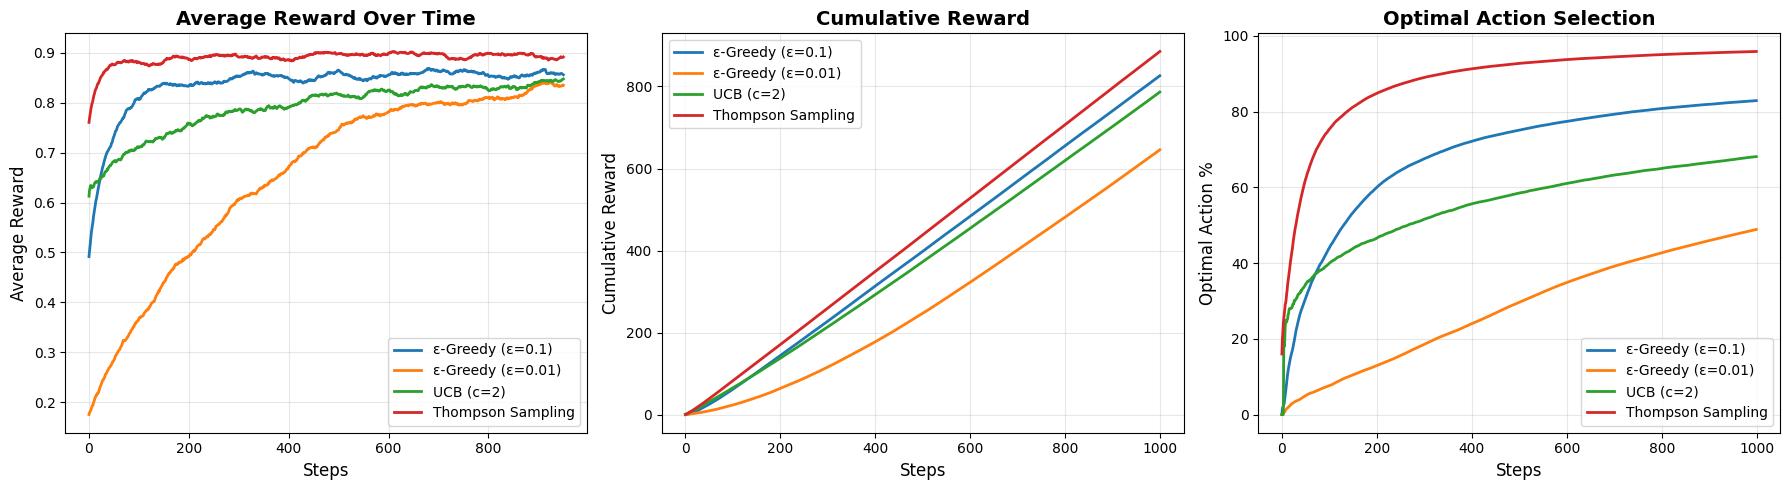

In [10]:
probabilities = [0.1, 0.3, 0.5, 0.7, 0.9]
print(f"Bandit probabilities: {probabilities}")
print(f"Optimal arm: {np.argmax(probabilities)} (probability: {max(probabilities)})")

# Run comparison
num_steps = 1000
num_runs = 100

results = run_comparison(probabilities, num_steps=num_steps, num_runs=num_runs)

# Print final statistics
print("\n" + "="*60)
print("FINAL RESULTS (averaged over {} runs)".format(num_runs))
print("="*60)
for name, data in results.items():
    final_cumulative = data['cumulative'][-1]
    final_optimal = data['optimal'][-1]
    print(f"\n{name}:")
    print(f"  Total Reward: {final_cumulative:.2f}")
    print(f"  Optimal Action %: {final_optimal:.2f}%")

# Plot results
plot_results(results, probabilities)